# Use Crocoddyl to run the trajectory

The idea of this page is to take the trajectory as an input (cost function) and see if crocoddyl can perform a feasable trajectory.

In [1]:
# import robot_loader from scripts
import pinocchio as pin
import crocoddyl
import os
import numpy as np
from scripts.robot_loader import launch_visualization
from scripts.trajectory_utils import convert_trajectory_to_pinocchio_format
import meshcat.geometry as mg

# I choose to make abstraction on this part as it is not really interesting. See the specific file for more details
# load model on Meshcat
model, collision_model, visual_model, robot_visualizer, viz = launch_visualization()

print(f"--- Pinocchio model datas ---")
print(f"Robot name: {model.name}")
print(f"Configuration dimension (nq): {model.nq}")
print(f"Velocity dimension (nv): {model.nv}")

# Path to trajectory datas 
trajectory_file = os.path.join("data", "h1v2_squat_fixed_ankle_states.npy")
raw_trajectory = np.load(trajectory_file)

# call conversion tool
q_trajectory, v_trajectory = convert_trajectory_to_pinocchio_format(raw_trajectory)

# Display first trajectory data
q0 = q_trajectory[0]
robot_visualizer.display(q0)

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/h1_2_description/h1_2_handless.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/h1_2_description
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.

Environment is ready !
--- Pinocchio model datas ---
Robot name: h1_2
Configuration dimension (nq): 34
Velocity dimension (nv): 33
raw trajectory dimension (raw_trajectory.shape): (176, 67)
q trajectory dimension (q_trajectory.shape): (176, 34)
v trajectory dimension (v_trajectory.shape): (176, 33)
Raw trajectory converted and separated into q and v trajectories.


In [2]:
# This code provide a visalization to create contact between the feets and the ground. 
# 
# on URDF, foot frames are in the middle of the foot, not on the flour
left_foot_middle_frame_id = model.getFrameId('left_ankle_roll_link')
right_foot_middle_frame_id = model.getFrameId('right_ankle_roll_link')

# offset to thune to match with the ground
CONTACT_Z_OFFSET = 0.05
offset_translation = np.array([0., 0., -CONTACT_Z_OFFSET])
contact_offset_pose = pin.SE3(np.eye(3), offset_translation)

# we had new frames to the model
left_contact_frame_name = "left_ground_contact"
right_contact_frame_name = "right_ground_contact"

if not model.existFrame(left_contact_frame_name):
    model.addFrame(pin.Frame(left_contact_frame_name,
                             model.frames[left_foot_middle_frame_id].parentJoint, # ID du joint parent
                             model.frames[left_foot_middle_frame_id].placement * contact_offset_pose, # Placement RELATIF au joint
                             pin.FrameType.OP_FRAME))

if not model.existFrame(right_contact_frame_name):
     model.addFrame(pin.Frame(right_contact_frame_name,
                              model.frames[right_foot_middle_frame_id].parentJoint,
                              model.frames[right_foot_middle_frame_id].placement * contact_offset_pose,
                              pin.FrameType.OP_FRAME))

data = model.createData()

# Maintenant, on récupère les ID de ces NOUVELLES frames, qui sont parfaitement positionnées
left_contact_id = model.getFrameId(left_contact_frame_name)
right_contact_id = model.getFrameId(right_contact_frame_name)

pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

# 2. Stocker la position/orientation de chaque pied dans le repère monde.
left_foot_ref_placement = data.oMf[left_contact_id].copy()
right_foot_ref_placement = data.oMf[right_contact_id].copy()


# --- this part is to thune CONTACT_Z_OFFSET ---
#sphere_geometry1 = mg.Sphere(0.04)
#left_ankle_pose = data.oMf[left_foot_middle_frame_id]
#sphere_pose = left_ankle_pose * contact_offset_pose
#red_material = mg.MeshLambertMaterial(color=0xff0000)
#viz[f"markers/{left_contact_frame_name}"].set_object(sphere_geometry1, red_material)
#viz[f"markers/{left_contact_frame_name}"].set_transform(sphere_pose.homogeneous)

#sphere_geometry2 = mg.Sphere(0.04)
#viz[f"markers/{right_foot_frame_id}"].set_object(sphere_geometry2, red_material)
#viz[f"markers/{right_foot_frame_id}"].set_transform(right_frame_pose.homogeneous)

### **Crocoddyl**
Now, we will implement crocoddyl trajectory.
The aim is to go from configuration x(q, v) to commands u = tau_q

### Step 1: Defining the Robotic System

We need to define the space state **x = (q, v)** and how to perform correct mathematical operations on them (given by pinocchio model).

Then, we need to define the output **u**, that will correspond to the torques of the actuated joints. At this point we need to specify that the robot has a floating base. 



### Step 2: Creating the Action Sequence ("Running Models")

This is a loop that runs for each trajectory point from **t=0** to **t=N-1**, with the same time interval provided by the trajectory.

1. convert the trajectory data so it is suitable to be used with pinocchio
2. Create the DAM (Differential Action Model). it contains the dynamics and the costs functions.
3. Define the costs and associated weights :
    - on the state point given by the trajectory (now customized in the yaml file
    - on the command to minimize the effort
    - on the contact
4. Discretize the model -> Transforms the continuous differential model into a discrete-time action model that the solver can use.
5. Stores the discretized action model for this time interval.     



### Step 3: Creating the Terminal Model

This is for the last point (**t=N**). The steps are the same than for the others points but we change the costs and weights.

Costs :
    - on the state given by the trajectory with high weight



### Step 4: Assembling the Full Problem

Assembles all the pieces into a single optimal control problem.


In [3]:
# I had bad result when adding the contact on crocoddyl (N > 4000N in Y - > see diagram in my computer). So I want to add a cost on the contacts
# cône friction ?

mu = 0.7

# Pour un sol horizontal, la matrice identité est ce qu'il faut.
# L'axe Z de cette matrice (la 3ème colonne) correspond à la normale [0, 0, 1].
R_cone = np.eye(3)

friction_cone = crocoddyl.FrictionCone(R_cone, mu)

# I will add gravity compensation at a first input for the command
v_zero = np.zeros(model.nv)
a_zero = np.zeros(model.nv)
full_gravity_torques = pin.rnea(model, data, q0, v_zero, a_zero)
actuated_gravity_torques = full_gravity_torques[6:]

print(f"\nDimension du vecteur RNEA complet: {len(full_gravity_torques)}") # Doit être 33
print(f"Dimension des couples moteurs extraits: {len(actuated_gravity_torques)}") # Doit être 27



Dimension du vecteur RNEA complet: 33
Dimension des couples moteurs extraits: 27


In [4]:
# I want to create customisable weight for every element of the trajectory.

import yaml

# I chose to set a manual configuration for weight on a yaml file
config_filepath = 'config/traj_weights.yaml'
with open(config_filepath, 'r') as f:
    config = yaml.safe_load(f)
print(f"Configuration des poids chargée : {config['description']}")

traj_weights_list = config['q_weights'] + config['v_weights']

traj_weights = np.array(traj_weights_list) # weights used on the state cost function
assert len(traj_weights) == 66, \
    f"Erreur de taille ! Votre fichier YAML a {len(traj_weights)} poids, mais l'état (state.nx) en a 66."

activation_weighted = crocoddyl.ActivationModelWeightedQuad(traj_weights**2)

Configuration des poids chargée : Fichier de configuration pour le squat.


In [5]:
# --- STEP 1 : Defining the Robotic System --- 
state = crocoddyl.StateMultibody(model) # input x = (q, v)
actuation = crocoddyl.ActuationModelFloatingBase(state) # output u = tau_q (with floating base taking into account)
print(f"Dimension de la vélocité via le state (state.nv): {state.nv}")
print(f"Dimension attendue par Crocoddyl (actuation.nu): {actuation.nu}") # Doit être 27

# --- STEP 2 : Creating the Action Sequence ("Running Models") ---
running_models = [] # for each point on the trajectory
dt = 0.03333  # Pas de temps de la discrétisation, je garde le meme que celui de la trajectoire initiale

q_trajectory, v_trajectory

for i in range(len(q_trajectory) - 1):

    # get trajectory point
    target_state = np.concatenate([q_trajectory[i+1], v_trajectory[i+1]])

    # 1. Costs
    running_costs = crocoddyl.CostModelSum(state, actuation.nu)
    
    # on the state point given by the trajectory
    residual_state = crocoddyl.ResidualModelState(state, target_state, actuation.nu)
    state_cost = crocoddyl.CostModelResidual(state, activation_weighted, residual_state)
    running_costs.addCost(name="state_cost", cost=state_cost, weight=1.0)
    
    # on the command to minimize the effort
    residual_control = crocoddyl.ResidualModelControl(state, actuation.nu)
    control_cost = crocoddyl.CostModelResidual(state, residual_control)
    running_costs.addCost(name="control_cost", cost=control_cost, weight=1e-4)

    # on the foots contact
    residual_friction_left = crocoddyl.ResidualModelContactFrictionCone(state, left_contact_id, friction_cone, actuation.nu)
    cost_friction_left = crocoddyl.CostModelResidual(state, residual_friction_left)
    running_costs.addCost(name="cost_friction_left", cost=cost_friction_left, weight=1e-2)

    residual_friction_right = crocoddyl.ResidualModelContactFrictionCone(state, right_contact_id, friction_cone, actuation.nu)
    cost_friction_right = crocoddyl.CostModelResidual(state, residual_friction_right)
    running_costs.addCost(name="cost_friction_right", cost=cost_friction_right, weight=1e-2)
    
    
    # 2. Contacts
    # create the contact container
    contact_model = crocoddyl.ContactModelMultiple(state, actuation.nu)
    # we define 2 contacts, one for each foot
    left_contact = crocoddyl.ContactModel6D(state, left_contact_id, left_foot_ref_placement, pin.LOCAL, actuation.nu)
    contact_model.addContact("left_foot_contact", left_contact)
    
    right_contact = crocoddyl.ContactModel6D(state, right_contact_id, right_foot_ref_placement, pin.LOCAL, actuation.nu)
    contact_model.addContact("right_foot_contact", right_contact)
    
    # 3. Differential Action Model (DAM)
    # Create a container to store the dynamics and costs
    diff_model = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, contact_model, running_costs)
    # DifferentialActionModelContactFwdDynamics use that for contacts DifferentialActionModelFreeFwdDynamics

    # 4. Create Integrated Action Model (IAM) using EUler. Could use RKR instead
    running_models.append(crocoddyl.IntegratedActionModelRK(diff_model, crocoddyl.RKType(4), dt))
    

# --- STEP 3 : Creating the Action Sequence ("Terminal Model") ---
final_state = np.concatenate([q_trajectory[-1], v_trajectory[-1]])

# 1. Costs
terminal_costs = crocoddyl.CostModelSum(state, actuation.nu)
residual_final_state = crocoddyl.ResidualModelState(state, final_state, actuation.nu)
terminal_state_cost = crocoddyl.CostModelResidual(state, residual_final_state)
terminal_costs.addCost(name="terminal_state_cost", cost=terminal_state_cost, weight=1e2)

# 2. Contacts
terminal_contact_model = crocoddyl.ContactModelMultiple(state, actuation.nu)
terminal_left_contact = crocoddyl.ContactModel6D(state, left_contact_id, pin.SE3.Identity(), pin.LOCAL, actuation.nu)
terminal_contact_model.addContact("left_foot_contact", terminal_left_contact)
terminal_right_contact = crocoddyl.ContactModel6D(state, right_contact_id, pin.SE3.Identity(), pin.LOCAL, actuation.nu)
terminal_contact_model.addContact("right_foot_contact", terminal_right_contact)

# 3. DAM
diff_model = crocoddyl.DifferentialActionModelContactFwdDynamics(state, actuation, terminal_contact_model, terminal_costs)

# 4. IAM
terminal_model = crocoddyl.IntegratedActionModelRK(diff_model, crocoddyl.RKType(4), 0.) # IntegratedActionModelRK IntegratedActionModelEuler


# --- STEP 4 : Assembling the Full Problem ---
x0 = np.concatenate([q_trajectory[0], v_trajectory[0]])
problem = crocoddyl.ShootingProblem(x0, running_models, terminal_model)

Dimension de la vélocité via le state (state.nv): 33
Dimension attendue par Crocoddyl (actuation.nu): 27


In [6]:
# DEBUG print

print(f"\n--- Dimensions de l'État Crocoddyl ---")
print(f"Dimension du vecteur d'état (nx):    {state.nx}")
print(f"Dimension de l'espace tangent (ndx): {state.ndx}")
print(f"Dimension de la commande (actuation.nu): {actuation.nu}")     # Doit être 27

print(f"\n--- Vérification ---")
print(f"Est-ce que nx = nq + nv ?  {state.nx == model.nq + model.nv}")
print(f"Est-ce que ndx = nv + nv ? {state.ndx == model.nv + model.nv}")


--- Dimensions de l'État Crocoddyl ---
Dimension du vecteur d'état (nx):    67
Dimension de l'espace tangent (ndx): 66
Dimension de la commande (actuation.nu): 27

--- Vérification ---
Est-ce que nx = nq + nv ?  True
Est-ce que ndx = nv + nv ? True


In [7]:
# Create an initial guess 
# we are looking at a problem with 176 states and 175 commands
# xs_init should be of size 176 -> we use the data on the trajectory as the first guess
# us_init should be of size 175 -> use gravity compensation computed earlier
xs_init = []
for i in range(len(q_trajectory)):
    x = np.concatenate([q_trajectory[i], v_trajectory[i]])
    xs_init.append(x)
print(f"xs_init dimension : {len(xs_init)}")

us_init = [actuated_gravity_torques] * 175
print(f"us_init dimension : {len(us_init)}")

print(f"Dimension de la commande attendue (nu): {actuation.nu}")
print(f"Dimension de la commande fournie:       {len(us_init[0])}")
if actuation.nu != len(us_init[0]):
    print("\n/!\\ ATTENTION: La dimension de us_init ne correspond pas à actuation.nu !\n")


xs_init dimension : 176
us_init dimension : 175
Dimension de la commande attendue (nu): 27
Dimension de la commande fournie:       27


In [8]:
# Create FDDP solver
solver = crocoddyl.SolverFDDP(problem)

solver.setCallbacks([
    crocoddyl.CallbackLogger(),
    #crocoddyl.CallbackVerbose()
])

# Appeler solve() en spécifiant l'estimation initiale et le nombre d'itérations
MAX_ITER = 2000  # On donne un nombre d'itérations suffisant
converged = solver.solve(xs_init, us_init, MAX_ITER)


# 5. Analyser les résultats
if converged:
    print("SUCCESS: FDDP converged.")
else:
    print("FAILURE: FDDP did not converge.")

FAILURE: FDDP did not converge.


In [8]:
# try mim_solver
import mim_solvers
import time
import math

solver = mim_solvers.SolverCSQP(problem)

solver.with_callbacks = True 
solver.termination_tolerance = 1e-3
solver.max_qp_iters = 1000
solver.eps_abs = 1e-5
solver.eps_rel = 0.
solver.use_filter_line_search = True


# On résout le problème !
print("Solving OCP...")
start_time = time.time()
solver.solve(xs_init, us_init)
end_time = time.time()
print(f"Solver finished in {end_time - start_time:.2f} seconds.")


Solving OCP...
Solver finished in 46.10 seconds.


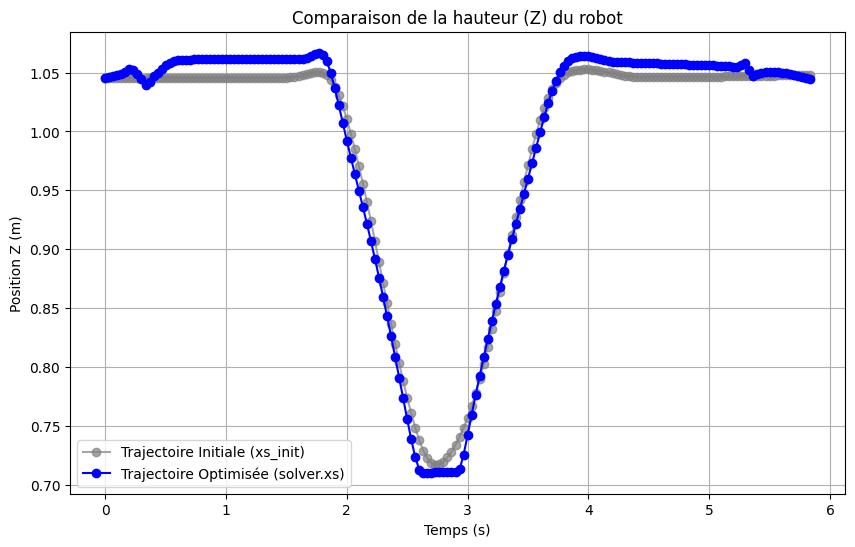

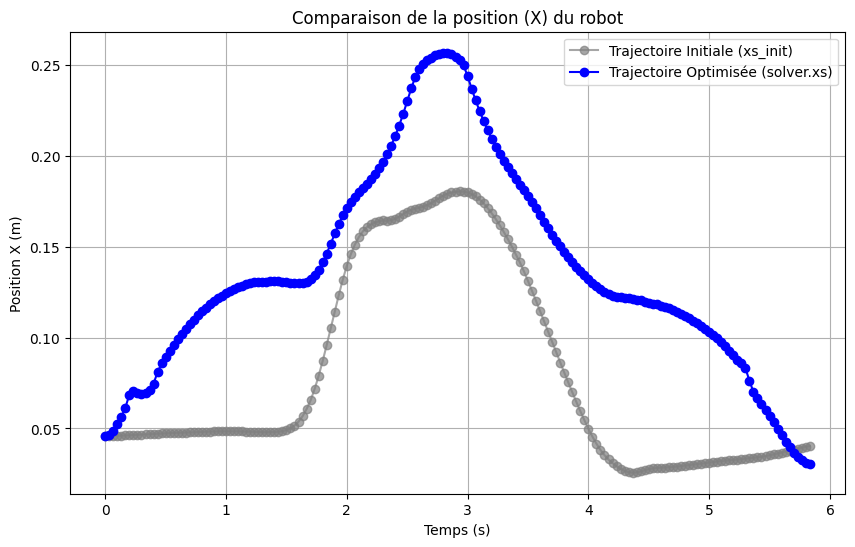

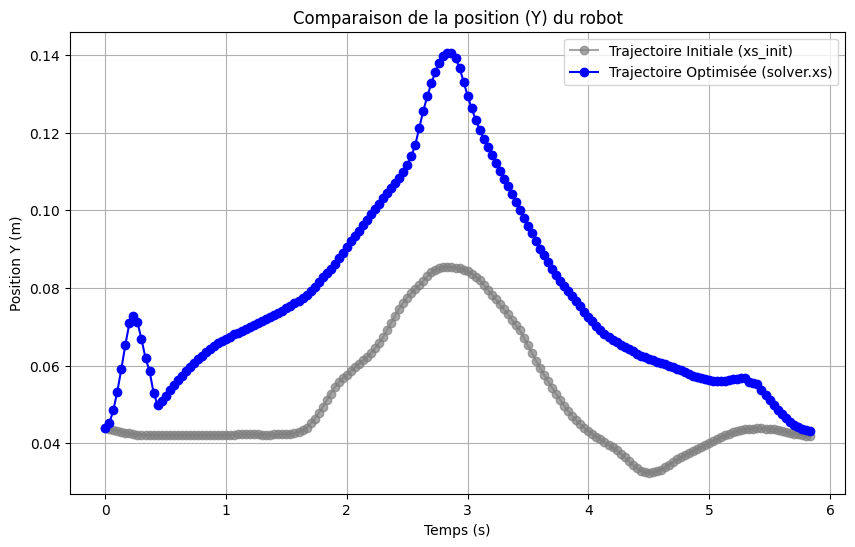

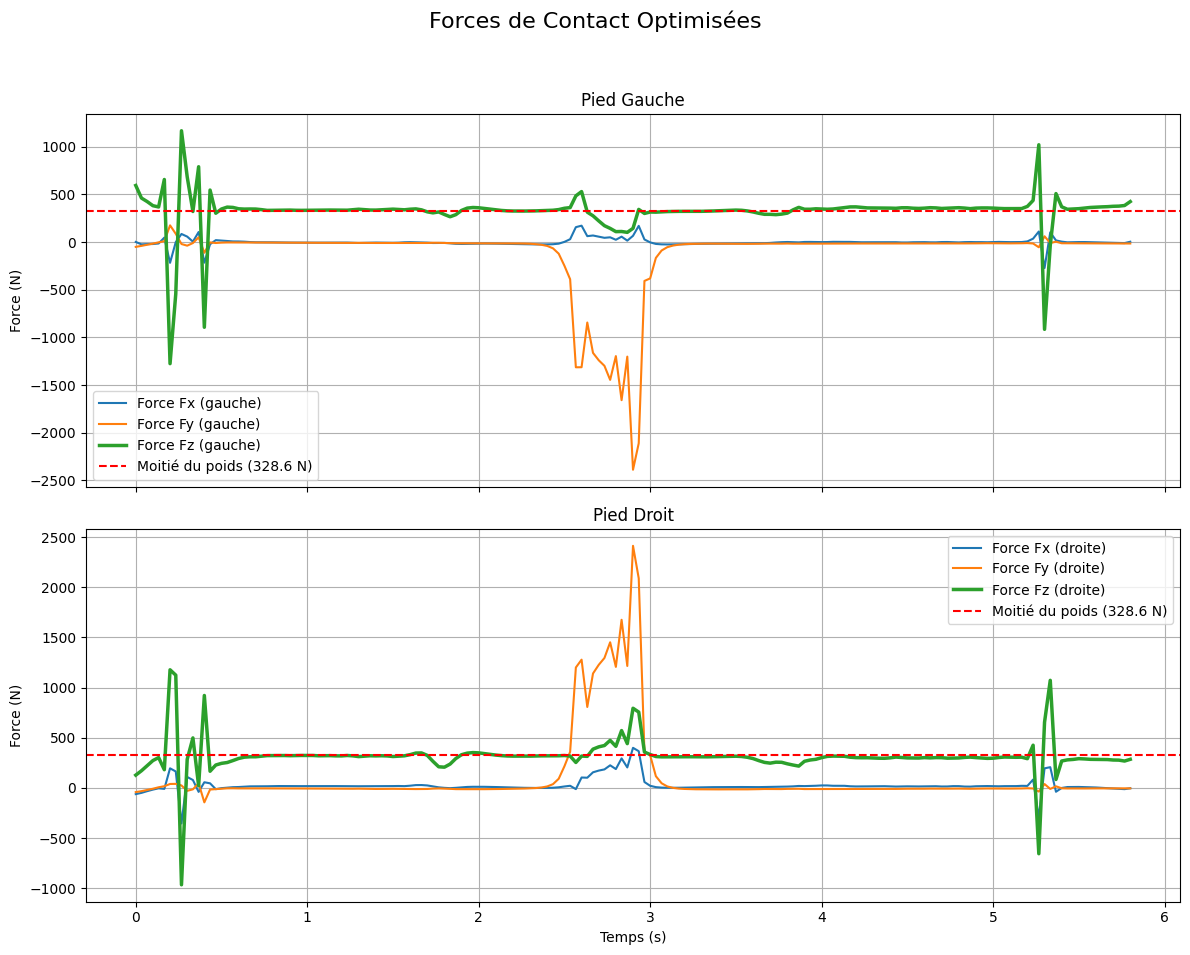

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer la solution depuis le solveur
xs_res = solver.xs
us_res = solver.us

# Extraire une coordonnée spécifique pour la visualisation
# L'index 2 correspond à la position en Z du 'floating base' dans Pinocchio (x,y,Z,qx,qy,qz,qw)
# Adaptez cet index si vous voulez voir autre chose (ex: un angle de joint)
z_initial = [x[2] for x in xs_init]
z_optimized = [x[2] for x in xs_res]

# Créer l'axe du temps pour le plot
time_axis = np.arange(len(xs_init)) * dt

# Plotter les résultats
plt.figure(figsize=(10, 6))
plt.plot(time_axis, z_initial, 'o-', label="Trajectoire Initiale (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, z_optimized, 'o-', label="Trajectoire Optimisée (solver.xs)", color='blue')
plt.title("Comparaison de la hauteur (Z) du robot")
plt.xlabel("Temps (s)")
plt.ylabel("Position Z (m)")
plt.legend()
plt.grid(True)
plt.show()

x_initial = [x[0] for x in xs_init]
x_optimized = [x[0] for x in xs_res]

# Plotter les résultats
plt.figure(figsize=(10, 6))
plt.plot(time_axis, x_initial, 'o-', label="Trajectoire Initiale (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, x_optimized, 'o-', label="Trajectoire Optimisée (solver.xs)", color='blue')
plt.title("Comparaison de la position (X) du robot")
plt.xlabel("Temps (s)")
plt.ylabel("Position X (m)")
plt.legend()
plt.grid(True)
plt.show()

y_initial = [x[1] for x in xs_init]
y_optimized = [x[1] for x in xs_res]

# Plotter les résultats
plt.figure(figsize=(10, 6))
plt.plot(time_axis, y_initial, 'o-', label="Trajectoire Initiale (xs_init)", color='gray', alpha=0.7)
plt.plot(time_axis, y_optimized, 'o-', label="Trajectoire Optimisée (solver.xs)", color='blue')
plt.title("Comparaison de la position (Y) du robot")
plt.xlabel("Temps (s)")
plt.ylabel("Position Y (m)")
plt.legend()
plt.grid(True)
plt.show()


# Assurez-vous d'avoir exécuté le solveur DDP avant ce code
# ddp.solve(xs_init, us_init, 500) # Exemple

# --- EXTRACTION DES FORCES DE CONTACT ---

# On récupère les données de chaque pas de temps (sauf le noeud terminal)
running_datas = solver.problem.runningDatas

left_forces = []
right_forces = []

for data in running_datas:
    # Le chemin d'accès correct pour le modèle ...ContactFwdDynamics est :
    # data.differential -> .multibody -> .contacts
    contact_datas = data.differential[0].multibody.contacts

    # Une fois qu'on a le gestionnaire de données de contact, on peut accéder
    # à chaque contact par son nom, comme prévu initialement.
    f_left = contact_datas.contacts['left_foot_contact'].f.vector
    f_right = contact_datas.contacts['right_foot_contact'].f.vector
    
    left_forces.append(f_left)
    right_forces.append(f_right)

# Conversion en tableaux NumPy pour un slicing facile
left_forces = np.array(left_forces)
right_forces = np.array(right_forces)

# Création de l'axe temporel
time_axis_f = np.arange(len(left_forces)) * dt


# --- AFFICHAGE DES FORCES (ce code reste identique) ---

# Création d'une figure avec deux sous-graphiques (un pour chaque pied)
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Forces de Contact Optimisées', fontsize=16)

# Graphique pour le pied gauche
axs[0].plot(time_axis_f, left_forces[:, 0], label="Force Fx (gauche)")
axs[0].plot(time_axis_f, left_forces[:, 1], label="Force Fy (gauche)")
axs[0].plot(time_axis_f, left_forces[:, 2], label="Force Fz (gauche)", linewidth=2.5)
axs[0].set_title("Pied Gauche")
axs[0].set_ylabel("Force (N)")
axs[0].grid(True)

# Graphique pour le pied droit
axs[1].plot(time_axis_f, right_forces[:, 0], label="Force Fx (droite)")
axs[1].plot(time_axis_f, right_forces[:, 1], label="Force Fy (droite)")
axs[1].plot(time_axis_f, right_forces[:, 2], label="Force Fz (droite)", linewidth=2.5)
axs[1].set_title("Pied Droit")
axs[1].set_xlabel("Temps (s)")
axs[1].set_ylabel("Force (N)")
axs[1].grid(True)

# Afficher le poids total du robot comme référence
try:
    robot_weight = pin.computeTotalMass(model) * 9.81
    axs[0].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Moitié du poids ({robot_weight/2:.1f} N)')
    axs[1].axhline(y=robot_weight/2, color='r', linestyle='--', label=f'Moitié du poids ({robot_weight/2:.1f} N)')
except NameError:
    print("La variable 'q0' n'est pas définie, impossible d'afficher le poids du robot.")

axs[0].legend()
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
# Launch the simulation
import time
print("Starting animation...")
dt = 0.033

xs_opt = solver.xs
xs_opt_array = np.array(solver.xs)
q_trajectory = xs_opt_array[:, :model.nq]

for q in q_trajectory:

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is 0.033333333 s
    time.sleep(0.033)

print("\nAnimation end.")

Starting animation...

Animation end.


In [ ]:
# Save output trajectory

from scripts.trajectory_utils import convert_pinocchio_to_trajectory_format

output_filename = 'data/crocoddyl_traj_13082025.npy'


v_trajectory = xs_opt_array[:, model.nq:]

x_opt_trajectory = convert_pinocchio_to_trajectory_format(q_trajectory, v_trajectory)

print(f"\nSaving the trajectory to '{output_filename}'...")
np.save(output_filename, x_opt_trajectory)

print(f"Trajectory successfully saved. Shape: {x_opt_trajectory.shape}")